In [1]:
import sklearn.metrics
import xgboost
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import shap
import os
import pickle
from graphviz import Source
from scipy import stats
plt.rcParams["font.sans-serif"]=["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

In [2]:
data = pd.read_excel("data_xgb.xlsx")

In [3]:
for col in data.columns:
    print(col, np.unique(data[col]))

学历 [1 2 3]
侧别 [1 2 3 4]
失语 [1 2]
额叶 [1 2]
颞叶 [1 2]
其他 [1 2]
病程分层12 [1 2 3 4 5]
言语智商 [ 30  31  32  34  36  37  38  40  41  42  43  44  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 118 119 120 121]
操作智商 [ 21  24  33  34  37  38  40  41  42  43  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105 108 109 110
 111 112 113 114 115 116 118]
全量表分-原始分 [  3   4   5   6   7  10  13  14  16  19  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  36  37  38  40  41  42  44  45  46  47  48
  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66  67
  68  69  70  7

In [4]:
data.columns

Index(['学历', '侧别', '失语', '额叶', '颞叶', '其他', '病程分层12', '言语智商', '操作智商',
       '全量表分-原始分', '全量表分'],
      dtype='object')

In [5]:
cols_bin = ['失语', 
            '额叶', '颞叶', '其他']
cols_order = ["学历", "病程分层12"]
cols_cat = ['侧别']
y_con = ['言语智商', '操作智商', '全量表分']
y_order = ['全量表分-原始分']

In [6]:
tmp = []
for col in cols_bin:
    result = stats.pointbiserialr(data[col], data["操作智商"])
    tmp.append([col, result[0], result[1]])

tmp = pd.DataFrame(tmp, columns=["特征", "correlation", "pvalue"]).sort_values(by="pvalue")
tmp

,特征,correlation,pvalue
0,失语,-0.497576,2.700320e-18
1,额叶,-0.161559,7.817286e-03
3,其他,-0.139029,2.231334e-02
2,颞叶,-0.131049,3.134570e-02


In [7]:
tmp = []
for col in cols_order:
    result = stats.kendalltau(data[col], data["操作智商"])
    tmp.append([col, result[0], result[1]])

tmp = pd.DataFrame(tmp, columns=["特征", "correlation", "pvalue"]).sort_values(by="pvalue")
tmp

,特征,correlation,pvalue
0,学历,0.080250,0.098943
1,病程分层12,-0.060771,0.191702


In [8]:
y = []
for i in range(data.shape[0]):
    if data["操作智商"][i]<70:
        y.append(0)
    elif data["操作智商"][i]<=90:
        y.append(1)
    else:
        y.append(2)

data["操作智商3分类"] = y
print (data["操作智商3分类"])

0      2
1      0
2      1
3      2
4      2
      ..
265    1
266    0
267    0
268    0
269    2
Name: 言语智商3分类, Length: 270, dtype: int64


In [9]:
tmp = []
for col in cols_order:
    result = stats.kendalltau(data[col], data["言语智商3分类"])
    tmp.append([col, result[0], result[1]])

tmp = pd.DataFrame(tmp, columns=["特征", "correlation", "pvalue"]).sort_values(by="pvalue")
tmp

,特征,correlation,pvalue
0,学历,0.062568,0.262020
1,病程分层12,-0.043630,0.413732


In [10]:
category = data.columns[:7]
raw_data = pd.concat([data.iloc[:, :7], data["言语智商3分类"]], axis=1)
def anova(frame):
    anova = pd.DataFrame()
    anova['feature'] = category
    pvals = []
    for c in category:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c]==cls]['言语智商3分类'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anova['pval'] = pvals
    return anova.sort_values('pval')

category_anova_result = anova(raw_data)
category_anova_result

,feature,pval
2,失语,2.952924e-17
1,侧别,3.961682e-11
3,额叶,2.443167e-03
4,颞叶,7.376713e-03
5,其他,1.812054e-02
0,学历,4.605170e-01
6,病程分层12,5.749993e-01


In [11]:
raw_data

,学历,侧别,失语,额叶,颞叶,其他,病程分层12,言语智商3分类
0,2,1,1,2,1,1,4,2
1,1,1,2,2,1,1,2,0
2,1,2,1,1,1,1,1,1
3,2,2,1,1,1,1,2,2
4,1,2,1,1,1,1,5,2
...,...,...,...,...,...,...,...,...
265,1,1,1,1,1,1,2,1
266,1,1,2,1,1,2,2,0
267,1,2,2,1,1,1,2,0
268,1,1,1,1,1,1,2,0


In [12]:
data

,学历,侧别,失语,额叶,颞叶,其他,病程分层12,言语智商,操作智商,全量表分-原始分,全量表分,言语智商3分类
0,2,1,1,2,1,1,4,104,86,99,95,2
1,1,1,2,2,1,1,2,63,104,75,80,0
2,1,2,1,1,1,1,1,81,85,57,82,1
3,2,2,1,1,1,1,2,99,81,90,90,2
4,1,2,1,1,1,1,5,104,112,118,108,2
...,...,...,...,...,...,...,...,...,...,...,...,...
265,1,1,1,1,1,1,2,81,97,75,87,1
266,1,1,2,1,1,2,2,53,80,24,63,0
267,1,2,2,1,1,1,2,62,73,27,65,0
268,1,1,1,1,1,1,2,49,56,13,48,0


In [13]:
X = data.iloc[:, :7]
# X = X.drop(columns=["糖尿病", "小脑", "高血脂", "脑室出血"])
y = data["言语智商3分类"]
data_dmatrix = xgb.DMatrix(data=X, label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.00001, random_state=0)
eval_set = [(X_train, y_train), (X_test, y_test)]

In [14]:
iters = 200
xgb_cv = xgb.cv(dtrain=data_dmatrix,params={"num_class":3,  "objective":"multi:softmax", "max_depth":3, "learning_rate":0.1}, nfold=5,
                    num_boost_round=iters, metrics="auc", as_pandas=True, seed = 123)
xgb_cv

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.810520,0.004371,0.741102,0.025104
1,0.811505,0.004725,0.742089,0.027725
2,0.813955,0.005732,0.747579,0.026423
3,0.815928,0.006277,0.744690,0.028044
4,0.816554,0.007183,0.746295,0.028293
...,...,...,...,...
195,0.900987,0.011696,0.721577,0.046988
196,0.901048,0.011794,0.722165,0.046489
197,0.901124,0.011815,0.722102,0.046722
198,0.901377,0.011897,0.721862,0.046764


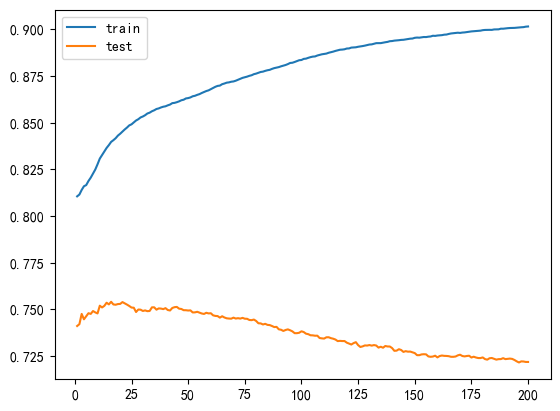

In [15]:
plt.plot(range(1, iters+1), xgb_cv["train-auc-mean"], label="train")
plt.plot(range(1, iters+1), xgb_cv["test-auc-mean"], label="test")
plt.legend()
plt.show()

In [16]:
from sklearn import metrics
tmp = []
for n_estimators in range(10, 200):
    xgb_cla = xgb.XGBClassifier(objective="multi:softproba", n_estimators=n_estimators, learning_rate=0.1, max_depth=3)
    xgb_cla.fit(X_train, y_train)
    tmp.append([n_estimators, metrics.accuracy_score(y_test, xgb_cla.predict(X_test))])

print(tmp)

[[10, 0.0], [11, 0.0], [12, 0.0], [13, 0.0], [14, 0.0], [15, 0.0], [16, 1.0], [17, 1.0], [18, 1.0], [19, 1.0], [20, 1.0], [21, 1.0], [22, 1.0], [23, 1.0], [24, 1.0], [25, 1.0], [26, 1.0], [27, 1.0], [28, 1.0], [29, 1.0], [30, 1.0], [31, 1.0], [32, 1.0], [33, 1.0], [34, 1.0], [35, 1.0], [36, 1.0], [37, 1.0], [38, 1.0], [39, 1.0], [40, 1.0], [41, 1.0], [42, 1.0], [43, 1.0], [44, 1.0], [45, 1.0], [46, 1.0], [47, 1.0], [48, 1.0], [49, 1.0], [50, 1.0], [51, 1.0], [52, 1.0], [53, 1.0], [54, 1.0], [55, 1.0], [56, 1.0], [57, 1.0], [58, 1.0], [59, 1.0], [60, 1.0], [61, 1.0], [62, 1.0], [63, 1.0], [64, 1.0], [65, 1.0], [66, 1.0], [67, 1.0], [68, 1.0], [69, 1.0], [70, 1.0], [71, 1.0], [72, 1.0], [73, 1.0], [74, 1.0], [75, 1.0], [76, 1.0], [77, 1.0], [78, 1.0], [79, 1.0], [80, 1.0], [81, 1.0], [82, 1.0], [83, 1.0], [84, 1.0], [85, 1.0], [86, 1.0], [87, 1.0], [88, 1.0], [89, 1.0], [90, 1.0], [91, 1.0], [92, 1.0], [93, 1.0], [94, 1.0], [95, 1.0], [96, 1.0], [97, 1.0], [98, 1.0], [99, 1.0], [100, 1.0

In [17]:
tmp = np.array(tmp)
best_n_estimators = tmp[np.argmax(tmp[:, 1]), 0]
best_n_estimators

16.0

In [18]:
xgb_cla = xgb.XGBClassifier(objective="multi:softproba", n_estimators=16, learning_rate=0.1, max_depth=3)
xgb_cla.fit(X_train, y_train)
from sklearn import metrics

print(metrics.accuracy_score(y_test, xgb_cla.predict(X_test)))
xgb_cla.predict_proba(X_test)

1.0


array([[0.16579822, 0.42846358, 0.40573826]], dtype=float32)

In [19]:
print(metrics.classification_report(y_test, xgb_cla.predict(X_test)))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



In [20]:
print(metrics.confusion_matrix(y_train, xgb_cla.predict(X_train)))

[[83 13 10]
 [20 40 21]
 [10 20 52]]


In [21]:
pd.DataFrame({"feature": X.columns, "feature_importances": xgb_cla.feature_importances_})

,feature,feature_importances
0,学历,0.107626
1,侧别,0.080083
2,失语,0.480703
3,额叶,0.071732
4,颞叶,0.164606
5,其他,0.055684
6,病程分层12,0.039565


In [167]:
print(metrics.classification_report(y_test, xgb_cla.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
